In [41]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
%load_ext autoreload
%autoreload 2
from ieee80211phy.transmitter.main import tx_generator
from ieee80211phy.receiver.packet_detector import *
from ieee80211phy.receiver.frequency_correction import *
from ieee80211phy.receiver.timing_acqusition import *
from ieee80211phy.util import *
import scipy 

import warnings
warnings.filterwarnings('ignore') # yolo!

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# pad_len = 100000
# noise = 0.00001 *  (0.70711 * np.random.randn(pad_len) + 0.70711 * np.random.randn(pad_len)*1j)

# to_tx = np.concatenate([tx, noise])

# def save_complex64_file(file: str, iq: np.array):
#     out = iq.astype(sp.complex64)
#     out.tofile(file)
#     return
# save_complex64_file('tx.raw', to_tx)
# plt.figure(figsize=(9.75,5))
# plt.plot(to_tx)
# plt.tight_layout()
# plt.grid()

# TX packet

Symbols: 109 Padding: 0


<IPython.core.display.Javascript object>


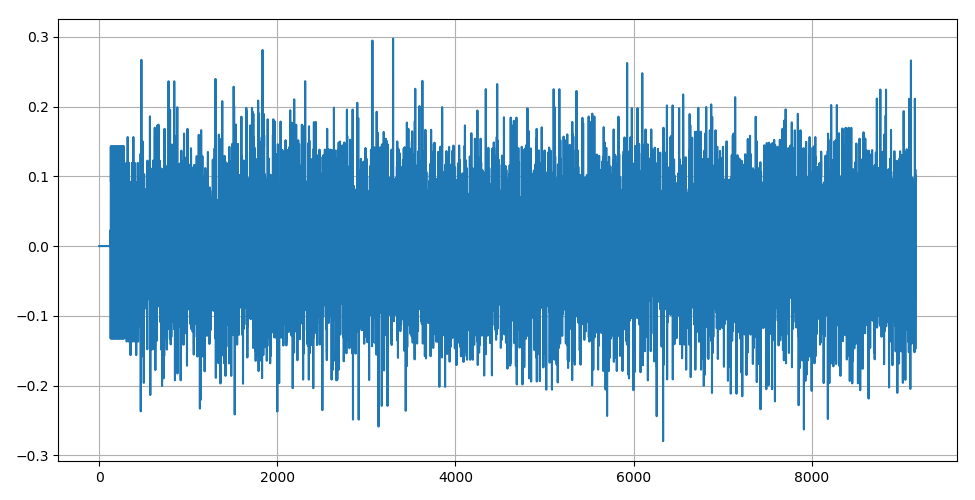

<IPython.core.display.Javascript object>


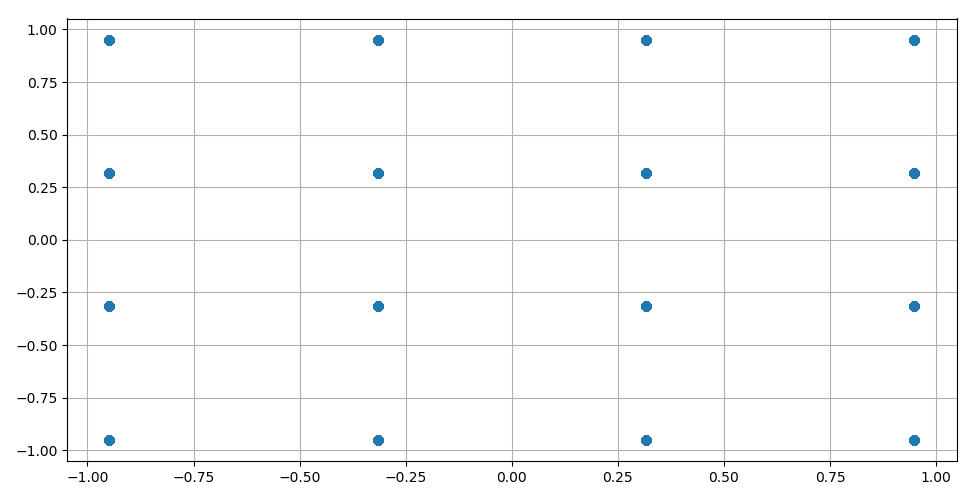

(5232,)


In [87]:
np.random.seed(0)
data = ''.join('1' if x else '0' for x in np.random.randint(2, size=20906))
tx, maps, ofdm_syms = tx_generator(data, data_rate=36)

pad_len = 128
noise = 0.00001 *  (0.70711 * np.random.randn(pad_len) + 0.70711 * np.random.randn(pad_len)*1j)
tx = np.concatenate([noise, tx])



plt.figure(figsize=(9.75,5))
plt.plot(tx)
plt.tight_layout()
plt.grid()


plt.figure(figsize=(9.75,5))
plt.scatter(maps.real, maps.imag)
plt.tight_layout()
plt.grid()
print(maps.shape)

# Channel

<IPython.core.display.Javascript object>


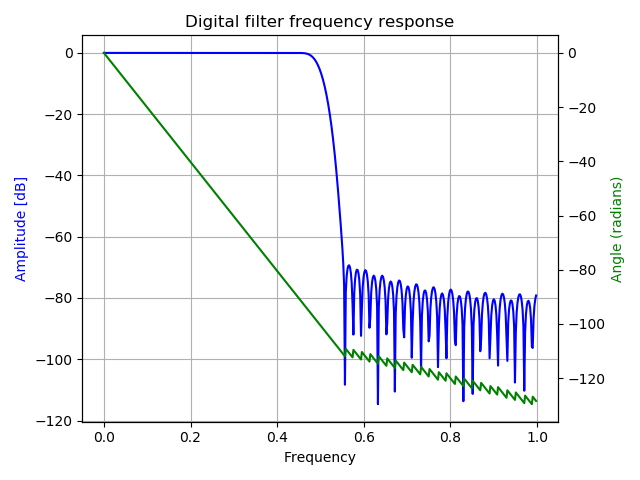

In [88]:
def show_freqz(taps):
    import matplotlib.pyplot as plt
    from scipy import signal
    w, h = signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
N = 128  # Filter order
bands = np.array([0., .22, .28, .5]) # Filter symetric around 0.25 (where .5 is pi or Fs/2)
halfband_taps =  signal.remez(N+1, bands, [1,0], [1,1])
halfband_taps[abs(halfband_taps) <= 1e-4] = 0.
show_freqz(halfband_taps)

In [167]:
def channel(tx, snr, freq_offset):
    up = scipy.signal.resample_poly(tx, 2, 1, window=halfband_taps)

    freq_offset = mixer(up, freq_offset, 40e6)
    rx = awgn(freq_offset, snr)
    rx = scipy.signal.resample_poly(rx, 1, 2, window=halfband_taps)
    return rx
# # rx = rx

# ss = np.exp

# plt.figure(figsize=(9.75,5))
# plt.plot(rx)
# plt.plot(tx)
# plt.tight_layout()
# plt.grid()

# Packet detection

255


<IPython.core.display.Javascript object>


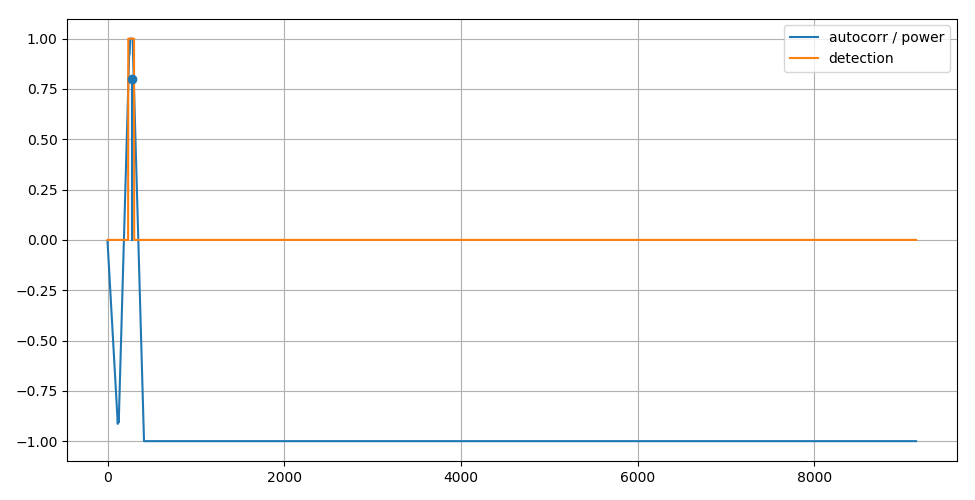

282


In [294]:
rx = channel(tx, snr=30, freq_offset=100e3)
start_of_long_training, ratio = packet_detector(rx, debug=True)
print(start_of_long_training)

# Freq offset detection

Coarse freq error is -98955.57243444398


<IPython.core.display.Javascript object>


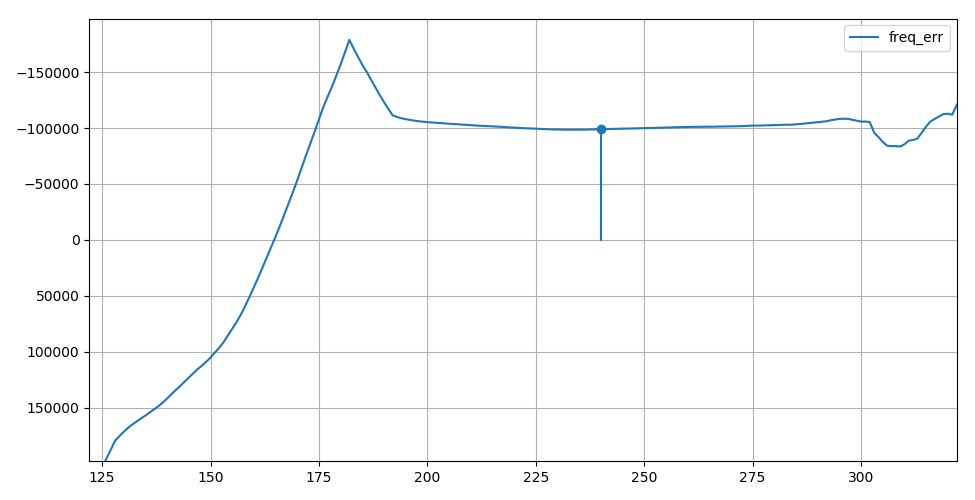

Fine freq error is 763.1333458692907


<IPython.core.display.Javascript object>


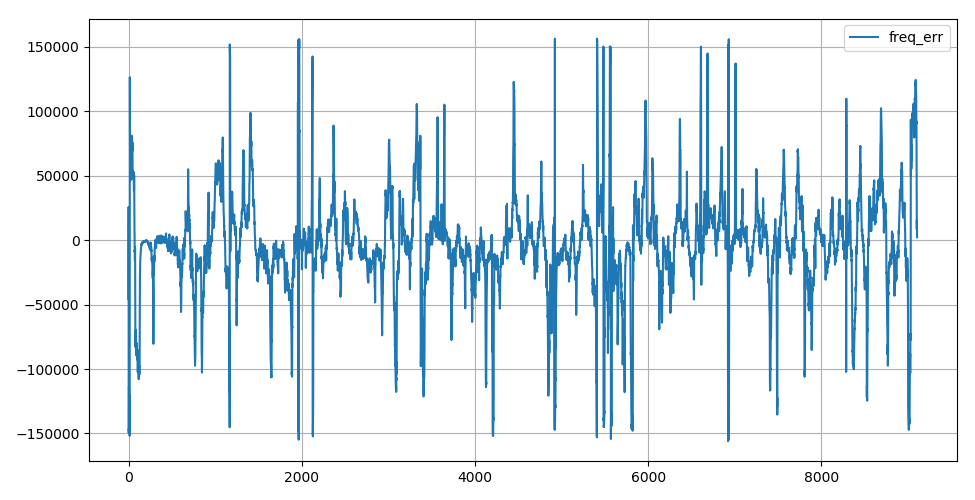

Total error corrected: -98192.43908857468


In [293]:
fixed_rx, error_coarse = fix_frequency_offset_coarse(rx, start_of_long_training, debug=True)
fixed_rx, error_fine = fix_frequency_offset_fine(fixed_rx, start_of_long_training, debug=True)
print(f'Total error corrected: {error_coarse + error_fine}')

# Timing

383
-231.55025001672342
-1550.8482457286555


<IPython.core.display.Javascript object>


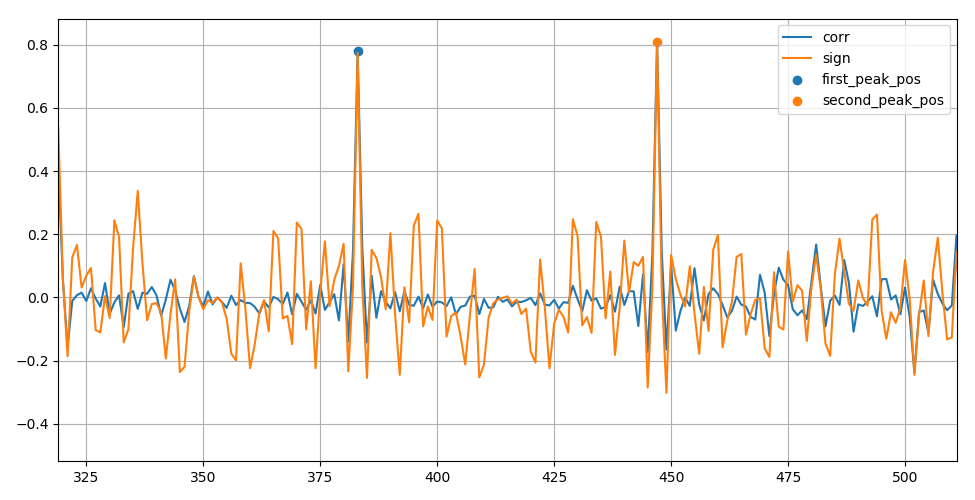

<IPython.core.display.Javascript object>


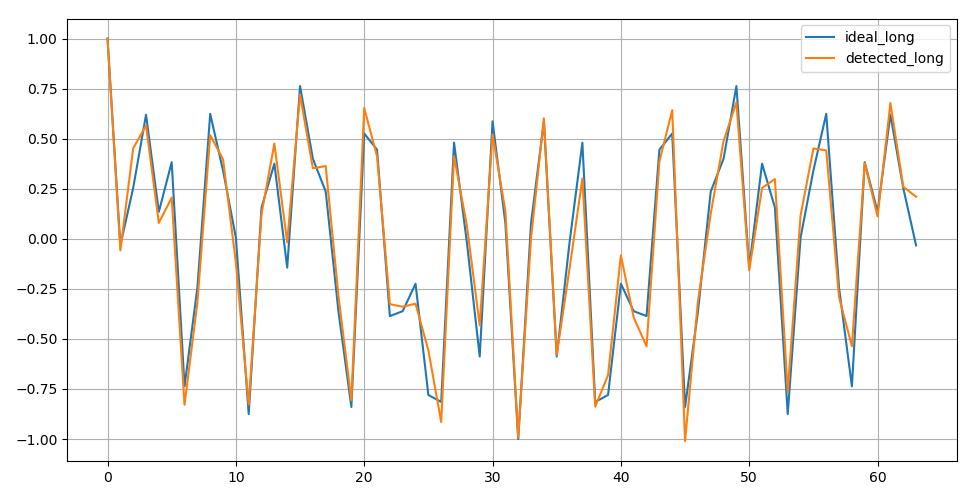

In [295]:
timing_acquisition(fixed_rx, start_of_long_training, True)

# Equalizer

In [ ]:
sample_advance = 0
from ieee80211phy.transmitter.preamble import *
ideal_long = long_train_symbol()
first_long_train = rx[192 - sample_advance:192+64 -sample_advance]
second_long_train = rx[192+64-sample_advance:192+64+64-sample_advance]
avg_long_train = (first_long_train + second_long_train) / 2
freq = np.fft.fft(avg_long_train)*(1/64)

print(np.fft.fft(ideal_long))
# ideal_freq  [0, 0, 0, 0, 0, 0, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1,
#                   1,
#                   0,
#                   1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 0, 0, 0, 0,
#                   0]

channel_estimate = freq / (np.fft.fft(ideal_long)*(1/64))
equalizer_coefs = 1/channel_estimate



plt.figure(figsize=(9.75,5))
plt.ylim([-2, 2])
plt.plot(np.fft.fftshift(20*np.log10(np.abs(equalizer_coefs))))
# plt.plot(equalizer_coefs)
# plt.plot(first_long_train)
# plt.plot(second_long_train)
# plt.plot(avg_long_train)
plt.tight_layout()
plt.grid()

# RX

In [ ]:
from ieee80211phy.transmitter.ofdm_modulation import *

no_head = rx[320-sample_advance:-1 - sample_advance]
symbols = np.reshape(no_head, (-1, 80))
freq = [np.fft.fft(x[16:]) for x in symbols]

equalized = freq
# print(equalizer_coefs)
# equalized = [x * equalizer_coefs for x in freq]
symbols = np.array([demap_from_carriers(x) for x in equalized])

symbols_flat = symbols.flatten()


In [ ]:
from ieee80211phy.util import *
plot_rx(symbols, ofdm_syms)

In [ ]:
plt.figure(figsize=(9.75,5))
plt.plot(symbols)
plt.plot(maps)
plt.tight_layout()
plt.grid()

In [ ]:
from ieee80211phy.transmitter.subcarrier_modulation_mapping import *
# symbols = np.array([QAM16_LUT_NORM[i>>2] + QAM16_LUT_NORM[i&3] * 1j for i in range(16)])
symbols = np.array([QAM64_LUT_NORM[i>>3] + QAM64_LUT_NORM[i&7] * 1j for i in range(64)])
print(symbols)
pwr = [power(x) for x in symbols]
print(pwr, np.mean(pwr))

plt.figure(figsize=(9.75,5))
plt.scatter(symbols.real, symbols.imag)
plt.tight_layout()
tick_base = 1 / np.sqrt(10)
plt.xticks([-4*tick_base, -2*tick_base, 0, tick_base*2, tick_base*4])
plt.yticks([-4*tick_base, -2*tick_base, 0, tick_base*2, tick_base*4])
plt.grid()